In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.odr import ODR, Model, Data

In [92]:
with open("/Users/joshuaalbiez/Documents/python/computer_vision_streamlit_app/random_points.pickle", "rb") as f:
    data = pickle.load(f)

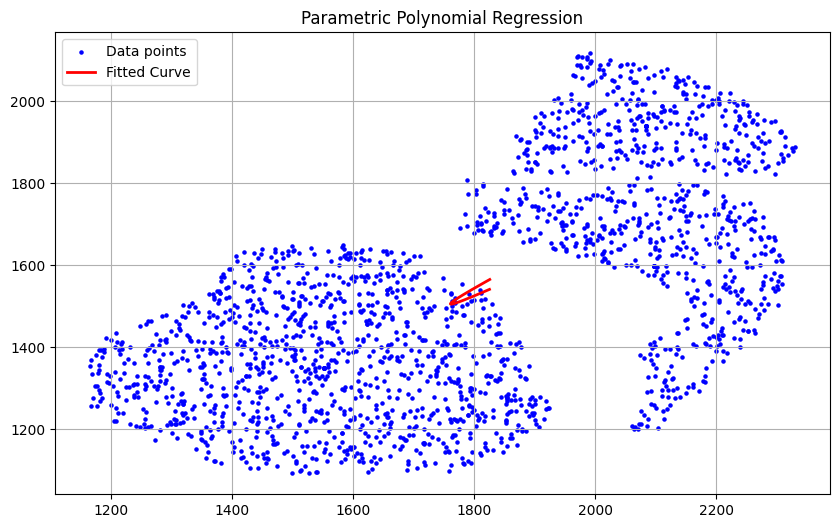

In [93]:
# Function to fit parametric regression
def fit_parametric_regression(data, degree=2):
    # Separate x and y values
    t = np.linspace(0, 1, len(data))
    x = data[:, 0]
    y = data[:, 1]

    # Fit x(t) and y(t) using polynomial regression
    x_coef = np.polyfit(t, x, degree)
    y_coef = np.polyfit(t, y, degree)

    # Generate fitted curves
    t_new = np.linspace(0, 1, 1000)  # More points for a smoother curve
    x_new = np.polyval(x_coef, t_new)
    y_new = np.polyval(y_coef, t_new)

    return np.column_stack((x_new, y_new))

# Fit the parametric polynomial regression on the data
fitted_points = fit_parametric_regression(data)

# Visualize the data alongside the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], s=5, color='blue', label='Data points')
plt.plot(fitted_points[:, 0], fitted_points[:, 1], color='red', linewidth=2, label='Fitted Curve')
plt.title('Parametric Polynomial Regression')
plt.legend()
plt.grid(True)
plt.show()


In [94]:
# ODR

In [95]:
def poly_func(beta, x):
    '''Define the polynomial function of degree n'''
    # Compute polynomial based on beta's length
    y = 0
    for i, coef in enumerate(beta):
        y += coef * (x ** i)
    return y

In [96]:
degree = 2

In [97]:
x = data[:, 0].reshape(-1, 1)
y = data[:, 1]
x = np.squeeze(x)
y = np.squeeze(y)

model = Model(poly_func)
data_obj = Data(x, y)
beta_vec = np.ones(degree + 1)
odr = ODR(data_obj, model, beta0=beta_vec)
output = odr.run()

# Print the estimated parameters
#print('Estimated parameters:', output.beta)
unique_x = np.unique(x)
y_fit = poly_func(output.beta, unique_x)

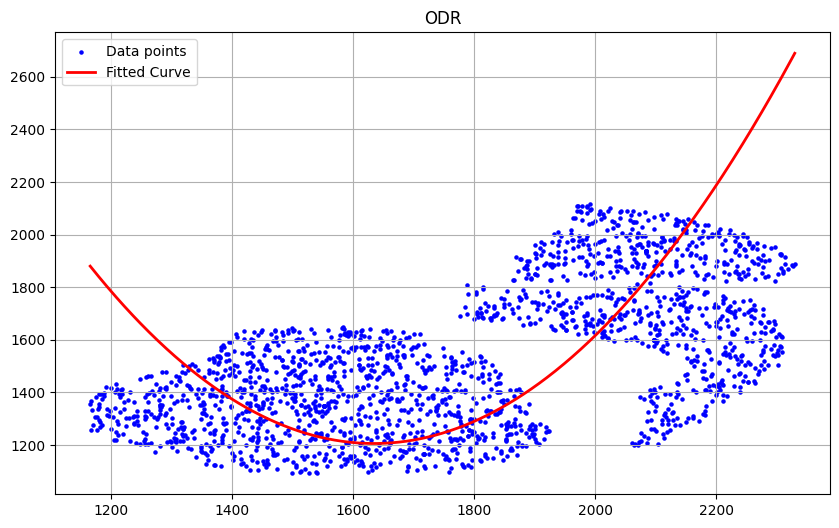

In [98]:
# Visualize the data alongside the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], s=5, color='blue', label='Data points')
plt.plot(unique_x, y_fit, color='red', linewidth=2, label='Fitted Curve')
plt.title('ODR')
plt.legend()
plt.grid(True)
plt.show()

In [124]:
def parametric_regression(x, y, degree=2):
    """
    Perform a parametric regression on the given 2D data.
    
    Parameters:
    - x, y: 1D arrays of data points.
    - degree: degree of the polynomial for the regression.
    
    Returns:
    - x_pred, y_pred: Predicted values after the regression.
    """
    # The independent parameter t
    t = np.linspace(0, 1, len(x))
    
    # Create polynomial features for t
    polynomial_features = PolynomialFeatures(degree=degree)
    T = polynomial_features.fit_transform(t.reshape(-1, 1))
    
    # Perform linear regressions
    reg_x = LinearRegression().fit(T, x)
    reg_y = LinearRegression().fit(T, y)
    
    # Predict using the trained regressions
    t_pred = np.linspace(0, 1, 1000)
    T_pred = polynomial_features.transform(t_pred.reshape(-1, 1))
    x_pred = reg_x.predict(T_pred)
    y_pred = reg_y.predict(T_pred)
    
    return x_pred, y_pred


In [125]:
x_values = data[:, 0]
y_values = data[:, 1]

In [126]:
print(y_values.min())

1093.0


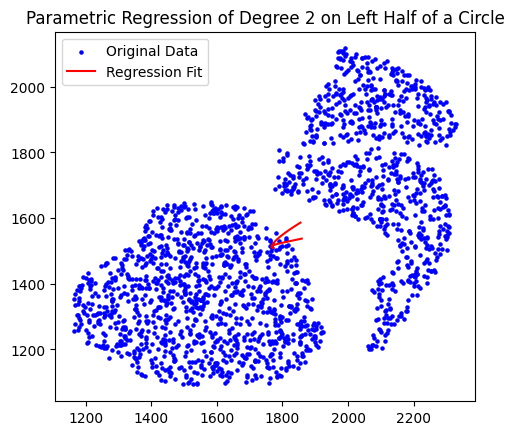

In [127]:
# Use the parametric regression on the synthetic data
x_pred, y_pred = parametric_regression(x_values, y_values, degree=4)

# Visualize the results
plt.scatter(x_values, y_values, color='blue', s=5, label="Original Data")
plt.plot(x_pred, y_pred, color='red', label="Regression Fit")
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Parametric Regression of Degree 2 on Left Half of a Circle')
plt.show()

In [128]:
class PointOrderer:
    def __init__(self, reference_points):
        self.reference_points = reference_points
        self.extended_reference_points = []
        self.extend_reference_line()

    def extend_line_from_point(self, point1, point2, x_min=0, y_min=0, x_max=4032, y_max=3040):
        """Extend a line formed by point1 and point2 from point1 in the opposite direction until it reaches a boundary."""
        m = (point2[1] - point1[1]) / (point2[0] - point1[0]) if point2[0] != point1[0] else float('inf')
        c = point1[1] - m * point1[0]
        
        if m == float('inf'):  # vertical line
            return (point1[0], y_max if point1[1] < point2[1] else y_min)
        
        y_at_x_min = m * x_min + c
        y_at_x_max = m * x_max + c
        x_at_y_min = (y_min - c) / m
        x_at_y_max = (y_max - c) / m

        if y_at_x_min >= y_min and y_at_x_min <= y_max and point1[0] > point2[0]:
            return (x_min, y_at_x_min)
        elif y_at_x_max >= y_min and y_at_x_max <= y_max and point1[0] < point2[0]:
            return (x_max, y_at_x_max)
        elif x_at_y_min >= x_min and x_at_y_min <= x_max and point1[1] > point2[1]:
            return (x_at_y_min, y_min)
        else:
            return (x_at_y_max, y_max)
        
    def extend_reference_line(self):
        start_boundary_point = self.extend_line_from_point(self.reference_points[1], self.reference_points[0])
        end_boundary_point = self.extend_line_from_point(self.reference_points[-2], self.reference_points[-1])
        self.extended_reference_points = [start_boundary_point] + self.reference_points + [end_boundary_point]

    def order_points(self, unordered_points):
        """Order the unordered points by projecting them onto the extended reference line."""
        def custom_sort(point):
            min_distance = float('inf')
            order_value = None
            for i in range(len(self.extended_reference_points) - 1):
                segment_start, segment_end = self.extended_reference_points[i], self.extended_reference_points[i+1]
                segment_vector = np.array(segment_end) - np.array(segment_start)
                point_vector = np.array(point) - np.array(segment_start)
                t = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)
                projection = np.array(segment_start) + t * segment_vector
                distance = np.linalg.norm(np.array(point) - projection)
                if distance < min_distance:
                    min_distance = distance
                    order_value = i + t  # Updated this to just t for better ordering
            return order_value

        ordered_points = sorted(unordered_points, key=custom_sort)
        return ordered_points


In [129]:
reference_points_example = [(2083.8438829839874, 1938.9957445124003), (2092.05960832858, 1737.5569242345175), (2097.7398033540653, 1598.2859850428665), (1721.1886664037554, 1426.581137812154), (1552.1107956902033, 1349.4827383860077)]
#reference_points_example = [(1478.623786421604, 720.1791107741248), (1570.5178506222576, 877.222034324436), (1672.091496266423, 1050.8069378367309), (1804.3288792169453, 1399.0233998383005), (1881.9101058795693, 1603.3155573465042)]

In [130]:
orderer = PointOrderer(reference_points_example)
ordered_points_example = orderer.order_points(data)

In [131]:
# convert list of tupple to numpy array
ordered_points_example = np.array(ordered_points_example)

In [132]:
x_values = ordered_points_example[:, 0]
y_values = ordered_points_example[:, 1]

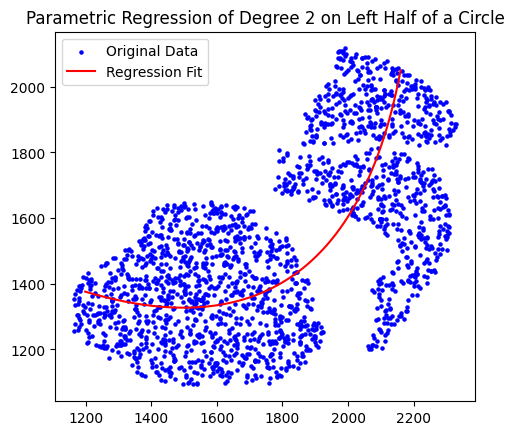

In [133]:
# Use the parametric regression on the synthetic data
x_pred, y_pred = parametric_regression(x_values, y_values, degree=2)

# Visualize the results
plt.scatter(x_values, y_values, color='blue', s=5, label="Original Data")
plt.plot(x_pred, y_pred, color='red', label="Regression Fit")
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Parametric Regression of Degree 2 on Left Half of a Circle')
plt.show()

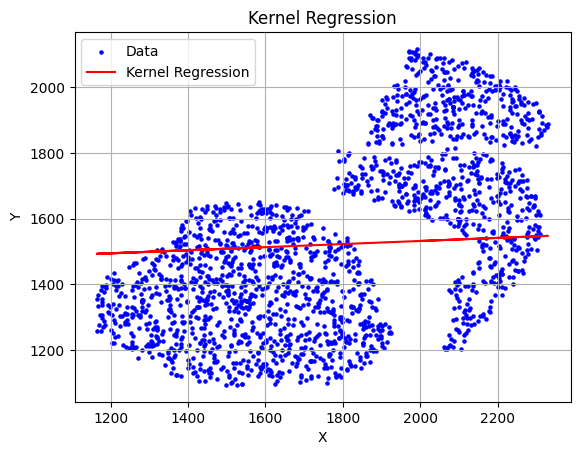

In [134]:
def gaussian_kernel(u):
    """Gaussian kernel function."""
    return np.exp(-u**2 / 2)

def kernel_regression(x, X, y, bandwidth):
    """Nadaraya-Watson kernel regression with Gaussian kernel."""
    weights = gaussian_kernel((x - X) / bandwidth)
    return np.sum(weights * y) / np.sum(weights)

# Extracting X and y from the data
X_data = ordered_points_example[:, 0]
y_data = ordered_points_example[:, 1]

# Define bandwidth (this can be tuned based on the data)
bandwidth = 1000

# Apply kernel regression to predict y values for each x in X_data
y_pred = [kernel_regression(x, X_data, y_data, bandwidth) for x in X_data]

# Plotting the data and the kernel regression estimates
plt.scatter(X_data, y_data, s=5, color='blue', label='Data')
plt.plot(X_data, y_pred, color='red', label='Kernel Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kernel Regression')
plt.legend()
plt.grid(True)
plt.show()

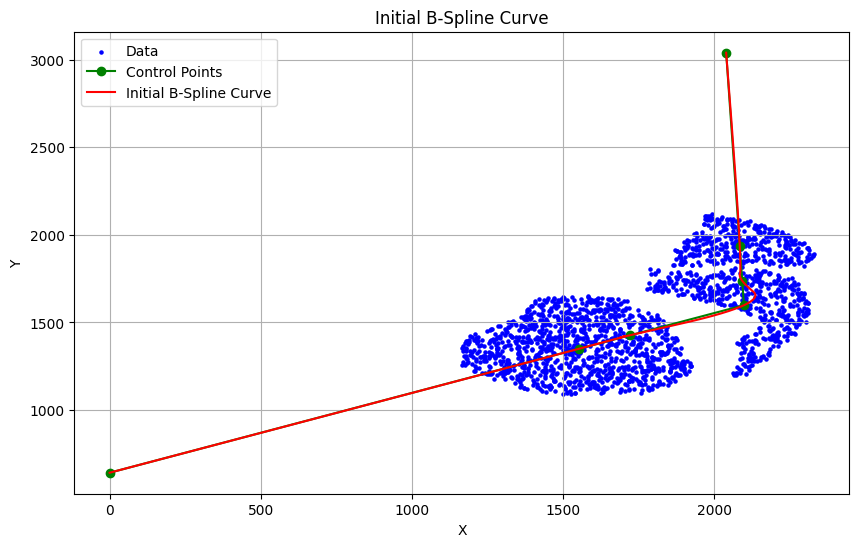

In [135]:
from scipy.interpolate import BSpline, make_interp_spline

# Extract X and Y coordinates of the reference points
reference_points_extended = np.array(orderer.extended_reference_points)
X_ref = [point[0] for point in reference_points_extended]
Y_ref = [point[1] for point in reference_points_extended]

# Generate the B-spline representation of the initial curve
t = np.linspace(0, 1, len(X_ref))
k = 2  # Degree of the spline. Here, we choose a quadratic spline
tck_initial = make_interp_spline(t, np.c_[X_ref, Y_ref], k=k)

# Evaluate the B-spline curve on a dense set of points for plotting
t_dense = np.linspace(0, 1, 1000)
initial_curve = tck_initial(t_dense)

plt.figure(figsize=(10, 6))
plt.scatter(X_data, y_data, s=5, color='blue', label='Data')
plt.plot(X_ref, Y_ref, 'go-', label='Control Points')
plt.plot(initial_curve[:, 0], initial_curve[:, 1], 'r-', label='Initial B-Spline Curve')
plt.title('Initial B-Spline Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


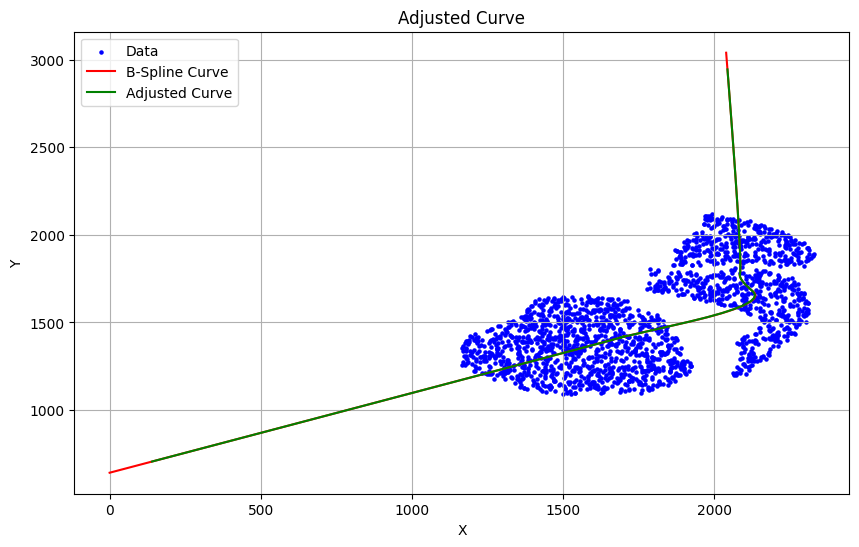

In [136]:
def project_point_to_line(point, line_start, line_end):
    """Project a point orthogonally onto a line segment."""
    line_vec = np.array(line_end) - np.array(line_start)
    point_vec = np.array(point) - np.array(line_start)
    line_length = np.linalg.norm(line_vec)
    
    # Normalize the line vector
    line_unit_vec = line_vec / line_length
    
    # Calculate the projection length
    proj_length = np.dot(point_vec, line_unit_vec)
    
    # Calculate the projection point on the line
    proj_point = line_start + proj_length * line_unit_vec
    
    return proj_point

def compute_adjusted_curve(tck, X_data, y_data, num_points=1000, window_size=0.02):
    """Compute the adjusted curve by walking along the B-spline curve."""
    t_values = np.linspace(0, 1, num_points)
    curve_points = tck(t_values)
    adjusted_points = []
    
    for i in range(1, len(t_values)):
        start_point = curve_points[i-1]
        end_point = curve_points[i]
        
        # Define a window around the current segment of the curve
        window_start = start_point - window_size * (end_point - start_point)
        window_end = end_point + window_size * (end_point - start_point)
        
        projections = []
        for point in zip(X_data, y_data):
            proj_point = project_point_to_line(point, window_start, window_end)
            # Check if the projection point is within the window
            if np.linalg.norm(proj_point - start_point) + np.linalg.norm(proj_point - end_point) <= np.linalg.norm(end_point - start_point):
                projections.append(proj_point)
        
        # Calculate the average of the projections
        if projections:
            avg_proj = np.mean(projections, axis=0)
            adjusted_points.append(avg_proj)
        else:
            adjusted_points.append((start_point + end_point) / 2)
    
    return np.array(adjusted_points)

# Compute the adjusted curve
adjusted_curve = compute_adjusted_curve(tck_initial, X_data, y_data, num_points=50, window_size=0.5)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_data, y_data, s=5, color='blue', label='Data')
plt.plot(initial_curve[:, 0], initial_curve[:, 1], 'r-', label='B-Spline Curve')
plt.plot(adjusted_curve[:, 0], adjusted_curve[:, 1], 'g-', label='Adjusted Curve')
plt.title('Adjusted Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


In [137]:
#new

NameError: name 'refined_curve' is not defined

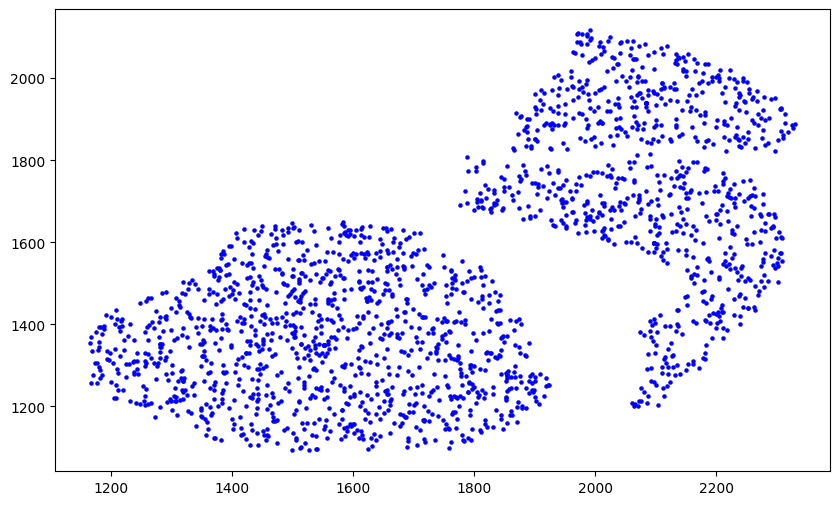

In [138]:
def compute_orthogonal_direction(p1, p2):
    """Compute the orthogonal direction to the line segment defined by p1 and p2."""
    dx, dy = p2[0] - p1[0], p2[1] - p1[1]
    return np.array([-dy, dx])

def compute_averaged_points(curve, data, window_size):
    """Compute averaged points for each point on the curve based on orthogonality to the curve segment."""
    averaged_points = []
    for i in range(1, len(curve) - 1):
        # Current segment
        p1, p2 = curve[i-1], curve[i+1]
        
        # Compute orthogonal direction
        ortho_dir = compute_orthogonal_direction(p1, p2)
        
        # Select points that are close and roughly orthogonal to the curve segment
        close_points = [pt for pt in data if np.linalg.norm(pt - curve[i]) < window_size]
        orthogonal_points = [pt for pt in close_points if np.dot(pt - curve[i], ortho_dir) > 0]
        
        # Compute the average of the orthogonal points
        if orthogonal_points:
            avg_point = np.mean(orthogonal_points, axis=0)
            averaged_points.append(avg_point)
        else:
            averaged_points.append(curve[i])
    
    return np.array(averaged_points)

# Parameters
window_size = 10  # This can be adjusted based on the data

# Compute the averaged points
averaged_points = compute_averaged_points(adjusted_curve, data, window_size)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_data, y_data, s=5, color='blue', label='Data')
plt.plot(refined_curve[:, 0], refined_curve[:, 1], 'r-', label='B-Spline Curve')
plt.plot(averaged_points[:, 0], averaged_points[:, 1], 'g-', label='Averaged Path')
plt.title('Refined Path by Averaging')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from scipy.optimize import minimize

def bspline_obj(ctrl_points, X, y, t, k):
    """Objective function to minimize for B-spline fitting."""
    tck = make_interp_spline(t, ctrl_points.reshape(-1, 2), k=k)
    y_pred = tck(X)
    return np.sum((y_pred[:, 1] - y) ** 2)

# Flatten the initial control points to make it 1D
ctrl_points_initial_flat = ctrl_points_initial.flatten()

# Optimization to fit the B-spline to the data
result = minimize(bspline_obj, ctrl_points_initial_flat, args=(X_data.ravel(), y_data, t, k), method='L-BFGS-B')
ctrl_points_optimized = result.x.reshape(-1, 2)

# Create the refined B-spline curve
tck_refined = make_interp_spline(t, ctrl_points_optimized, k=k)
refined_curve = tck_refined(t_dense)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_data, y_data, s=5, color='blue', label='Data')
plt.plot(ctrl_points_optimized[:, 0], ctrl_points_optimized[:, 1], 'go-', label='Optimized Control Points')
plt.plot(refined_curve[:, 0], refined_curve[:, 1], 'r-', label='Refined B-Spline Curve')
plt.title('Refined B-Spline Curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'ctrl_points_initial' is not defined

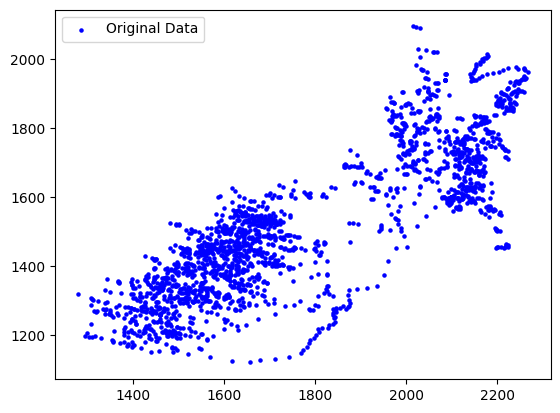

In [ ]:
# Compute average of ordered points and visualize
ordered_points_example = np.array(ordered_points_example)
x_values = ordered_points_example[:, 0]
y_values = ordered_points_example[:, 1]

#iterate over ordered points and compute average by using sliding window of 10 points
averaged_points = []
for i in range(0, len(x_values)-10):
    averaged_points.append(np.mean(ordered_points_example[i:i+10], axis=0))
averaged_points = np.array(averaged_points)

x_values = averaged_points[:, 0]
y_values = averaged_points[:, 1]

# Plot average of ordered points
plt.scatter(x_values, y_values, color='blue', s=5, label="Original Data")
plt.legend()
plt.show()


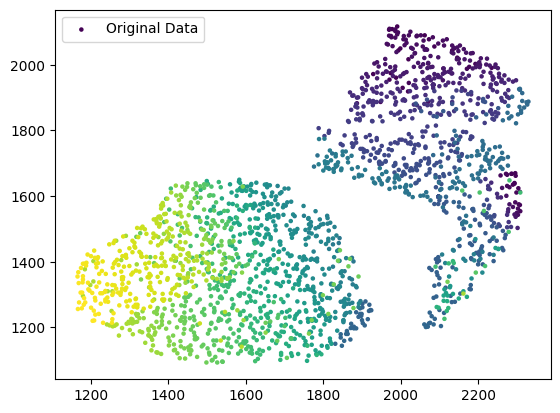

In [ ]:
#visualize ordered points by using a color gradient
x_values = ordered_points_example[:, 0]
y_values = ordered_points_example[:, 1]

# Plot average of ordered points
plt.scatter(x_values, y_values, c=np.arange(len(x_values)), cmap='viridis', s=5, label="Original Data")
plt.legend()
plt.show()

# Kernel regression

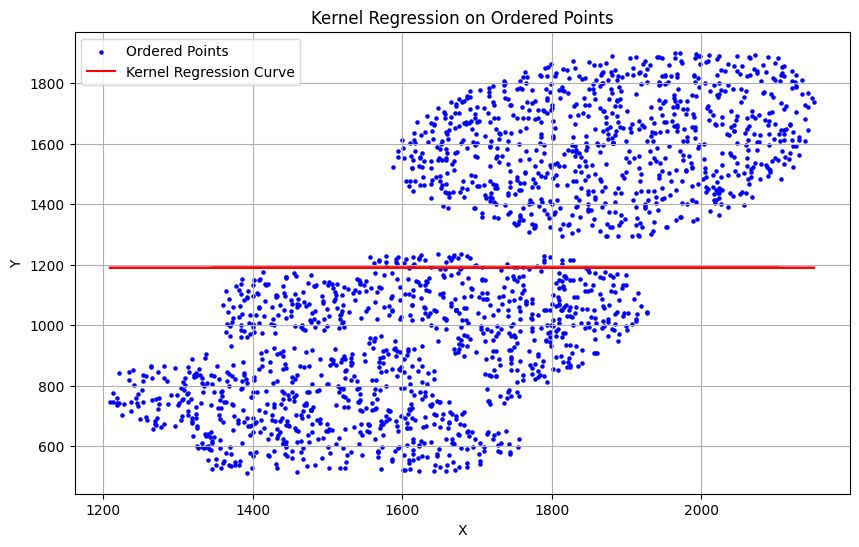

In [ ]:
from sklearn.kernel_ridge import KernelRidge

# Extract X and Y from the ordered data
X_ordered = np.array([pt[0] for pt in ordered_points_example]).reshape(-1, 1)
y_ordered = np.array([pt[1] for pt in ordered_points_example])

# Perform kernel regression
kr = KernelRidge(kernel='sigmoid', degree=2)
y_kr = kr.fit(X_ordered, y_ordered).predict(X_ordered)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_ordered, y_ordered, s=5, color='blue', label='Ordered Points')
plt.plot(X_ordered, y_kr, color='red', label='Kernel Regression Curve')
plt.title('Kernel Regression on Ordered Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from scipy.interpolate import splprep, splev

def spline_interpolation_and_plot(X, Y, s=None):
    """
    Fit a spline on the provided X and Y coordinates and plot the results (further adjusted version).
    
    Parameters:
    - X: Array of x-coordinates.
    - Y: Array of y-coordinates.
    - s: Smoothing parameter for the spline. If None, it uses the default.
    
    Returns:
    - Visualization with the fitted spline.
    """
    
    # Remove duplicates
    data = np.array([X, Y]).T
    data = np.unique(data, axis=0)
    X, Y = data[:, 0], data[:, 1]
    
    # Fit the spline
    tck, u = splprep([X, Y], u=None, per=0, s=s, k=3)
    
    # Evaluate the spline
    u_new = np.linspace(0, 1, len(X))
    x_new, y_new = splev(u_new, tck, der=0)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y, c='red', marker='o', label='Original Points')
    plt.plot(x_new, y_new, '-k', label='Fitted Spline')
    plt.axis('equal')
    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Spline Interpolation on Data Points')
    plt.grid(True)
    plt.show()


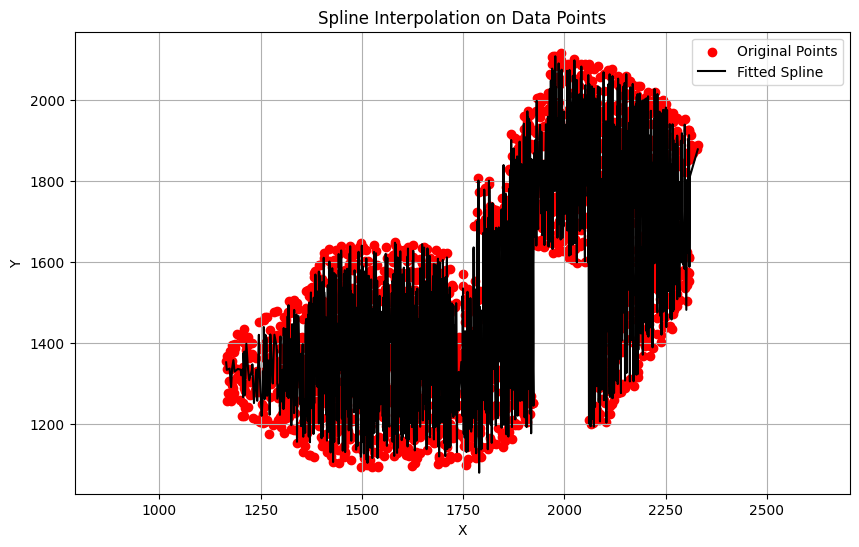

In [ ]:
# Extracting X and Y coordinates from the ordered points for demonstration
X_demo, Y_demo = np.array(ordered_points_example).T

# Example usage:
spline_interpolation_and_plot(X_demo, Y_demo, s=1000000)

# Piecewise linear

In [ ]:
def refine_endpoints_by_density(piecewise_points, density_map, indices_to_refine, iterations=10, alpha=0.1):
    """Refine specific endpoints of the piecewise linear graph based on the density map."""
    refined_points = piecewise_points.copy()
    for _ in range(iterations):
        for i in indices_to_refine:
            refined_points[i] = tuple(pull_point_by_density(refined_points[i], density_map, alpha))
    return refined_points

# Indices of endpoints to refine
endpoints_indices = [0, 6]

# Refine the endpoints using the density map
refined_endpoints = refine_endpoints_by_density(reference_points_extended, density_map, endpoints_indices, iterations=100, alpha=2)

# Visualization
plt.figure(figsize=(10, 7))
plt.scatter(*zip(*scatter_points), color='blue', s=10, label="Scatter Points")
plt.plot(*zip(*extended_points), color='red', linestyle='--', label="Original Extended Graph")
plt.plot(*zip(*refined_endpoints), color='green', label="Refined Endpoints")
plt.contour(density_map[0], density_map[1], density_map[2], levels=10, cmap="Purples", label="Density Contours")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.title("Refined Endpoints of Extended Graph Based on Scatter Point Density")
plt.grid(True)
plt.show()


NameError: name 'density_map' is not defined

In [ ]:
import numpy as np
import scipy.stats


In [ ]:
class GraphRefiner:
    
    def __init__(self, control_points, scatter_points, alpha=0.1, iterations=100):
        self.control_points = control_points
        self.scatter_points = scatter_points
        self.density_map = self.compute_density_map()
        self.refined_points = self.refine_endpoints(iterations=iterations, alpha=alpha)
    
    def compute_density_map(self, grid_size=100):
        """Compute a 2D density map using gaussian KDE."""
        kde = scipy.stats.gaussian_kde(np.array(self.scatter_points).T)
        x_grid = np.linspace(min(np.array(self.scatter_points)[:,0]), max(np.array(self.scatter_points)[:,0]), grid_size)
        y_grid = np.linspace(min(np.array(self.scatter_points)[:,1]), max(np.array(self.scatter_points)[:,1]), grid_size)
        X, Y = np.meshgrid(x_grid, y_grid)
        Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))
        return X, Y, Z.reshape(X.shape)
    
    def pull_point_by_density(self, point, alpha=0.1):
        """Pull a point based on the density map."""
        X, Y, Z = self.density_map
        gradient_x = np.gradient(Z, axis=1)
        gradient_y = np.gradient(Z, axis=0)
        
        # Interpolate gradient at the given point
        grad_x_interp = np.interp(point[0], X[0, :], gradient_x[int(len(X) / 2)])
        grad_y_interp = np.interp(point[1], Y[:, 0], gradient_y[:, int(len(Y) / 2)])
        
        # Compute the direction to move
        direction = np.array([grad_x_interp, grad_y_interp])
        direction /= (np.linalg.norm(direction) + 1e-9)  # Normalize
        
        # Move the point
        new_point = np.array(point) + alpha * direction
        return new_point
    
    def refine_endpoints(self, iterations=100, alpha=2):
        """Refine the endpoints of the graph based on the density map."""
        refined_points = self.control_points.copy()
        for _ in range(iterations):
            for i in [0, -1]:
                refined_points[i] = tuple(self.pull_point_by_density(refined_points[i], alpha))
        return refined_points
    
    def get_refined_points(self):
        """Return the refined points after optimization."""
        return self.refined_points

# Providing the updated class definition for GraphRefiner


In [ ]:
# Example usage
refiner = GraphRefiner(reference_points_extended, data, alpha=1, iterations=500)
optimized_points = refiner.get_refined_points()
optimized_points

array([[2112.66604334, 2936.44941776],
       [2083.84388298, 1938.99574451],
       [2092.05960833, 1737.55692423],
       [2097.73980335, 1598.28598504],
       [1721.1886664 , 1426.58113781],
       [1552.11079569, 1349.48273839],
       [   3.17298805, 1137.06184967]])

In [ ]:
import matplotlib.pyplot as plt

class GraphVisualizer:
    
    def __init__(self, scatter_points, original_points, refined_points):
        self.scatter_points = scatter_points
        self.original_points = original_points
        self.refined_points = refined_points
    
    def plot_graph(self):
        """Plot the scatter points, original graph, and refined graph."""
        plt.figure(figsize=(10, 7))
        plt.scatter(*zip(*self.scatter_points), color='blue', s=10, label="Scatter Points")
        plt.plot(*zip(*self.original_points), color='red', linestyle='--', label="Original Graph")
        plt.plot(*zip(*self.refined_points), color='green', label="Refined Graph")
        plt.xlabel("X-axis")
        plt.xlim(0, 4032)
        plt.ylim(0, 3040)
        plt.ylabel("Y-axis")
        plt.legend()
        plt.grid(True)
        plt.title("Original vs. Refined Graph")
    
    def show(self):
        """Display the plot."""
        plt.show()

# Providing the GraphVisualizer class definition


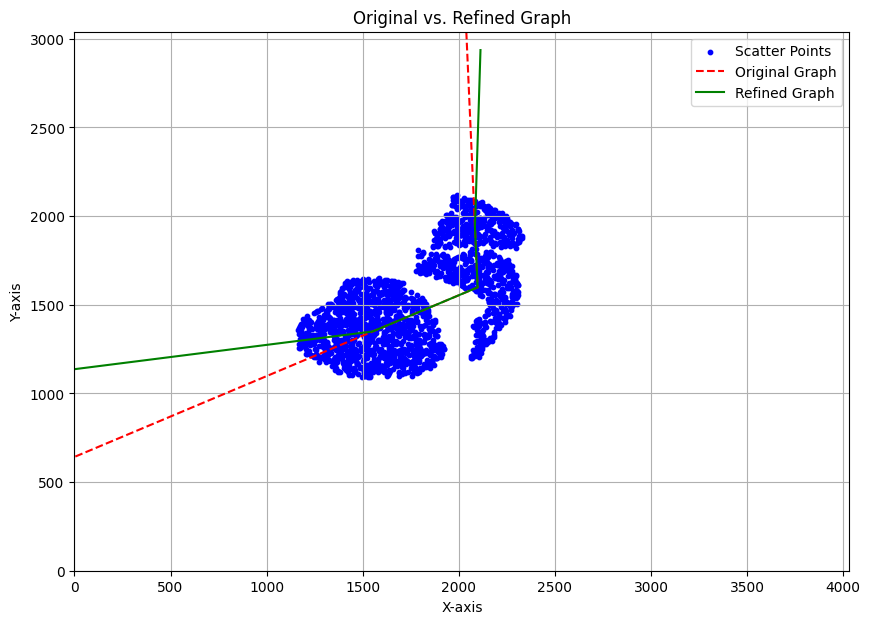

In [ ]:
visualizer = GraphVisualizer(data, reference_points_extended, optimized_points)
visualizer.plot_graph()
